# Coffee Bean Dataset

In [137]:
# !pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="API")
project = rf.workspace("yolo-annotated-dataset").project("usk-coffe")
dataset = project.version(2).download("darknet")


loading Roboflow workspace...
loading Roboflow project...




Extracting Dataset Version Zip to USK-Coffe-2 in darknet::   0%|          | 0/16008 [00:00<?, ?it/s]
Extracting Dataset Version Zip to USK-Coffe-2 in darknet::   5%|▌         | 832/16008 [00:00<00:01, 8317.91it/s]
Extracting Dataset Version Zip to USK-Coffe-2 in darknet::  10%|█         | 1664/16008 [00:00<00:02, 5920.66it/s]
Extracting Dataset Version Zip to USK-Coffe-2 in darknet::  15%|█▍        | 2328/16008 [00:00<00:02, 6188.84it/s]
Extracting Dataset Version Zip to USK-Coffe-2 in darknet::  19%|█▊        | 2998/16008 [00:00<00:02, 6364.92it/s]
Extracting Dataset Version Zip to USK-Coffe-2 in darknet::  23%|██▎       | 3680/16008 [00:00<00:01, 6514.80it/s]
Extracting Dataset Version Zip to USK-Coffe-2 in darknet::  27%|██▋       | 4345/16008 [00:00<00:01, 6291.70it/s]
Extracting Dataset Version Zip to USK-Coffe-2 in darknet::  31%|███▏      | 5030/16008 [00:00<00:01, 6462.02it/s]
Extracting Dataset Version Zip to USK-Coffe-2 in darknet::  36%|███▌      | 5684/16008 [00:01<00:03,

In [136]:
from glob import glob
import cv2
from pathlib import Path
import os

In [138]:
txts = glob("./USK-Coffe-2/test/*.txt")

In [140]:
!mkdir -p cropped/normal
!mkdir -p cropped/abnormal

In [141]:
# Crop images

for txt in txts:
  with open(txt, "r") as f:
    labels = f.readline().split(" ")
    labels = map(float, labels)
    label, xc, yc, w, h = labels
    txt_path = Path(txt)
    img_path = str(txt_path.parent / txt_path.stem) + ".jpg"
    class_label = "normal" if label != 0 else "abnormal"
    save_path = os.path.join("cropped", class_label, txt_path.stem + ".jpg")
    print(img_path)
    image = cv2.imread(img_path)
    image_width = image.shape[1]
    image_height = image.shape[0]
    x_min = (xc - w / 2) * image_width
    x_max = (xc + w / 2) * image_width
    y_min = (yc - h / 2) * image_height
    y_max = (yc + h / 2) * image_height

    cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
    cv2.imwrite(save_path, cropped_image)

/content/Anomalib-Trainer/USK-Coffe-2/test/1923_jpg.rf.0b53d19895fd4a21e142446dd212ffa0.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1836_jpg.rf.a3e7dc2090d2525e90d5d710c7ae1450.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1969_jpg.rf.c2a842204bc95e52d4a4df2dada1294c.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1671_jpg.rf.2a61ac68b0e588892f22292da93d330a.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1984_jpg.rf.2180d255ac655c0d7379915af945fefb.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1701_jpg.rf.91d254dfca9db3efe0dde99416457750.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1891_jpg.rf.494029b2c4ff0dc449cc2dd2aa56093e.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1960_jpg.rf.ed45c3de6f1c5c273fe800c03b128358.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1955_jpg.rf.6497cf7389bec63846c308927860bd6e.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1865_jpg.rf.30e51712a1c579363ba852d96509e1d8.jpg
/content/Anomalib-Trainer/USK-Coffe-2/test/1975_jpg.rf.f1df834a2ec11d8498b0b8542

# Train

In [ ]:
!pip install -U anomalib

In [61]:
import anomalib

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import TestSplitMode
from anomalib.models import get_model
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.utils.loggers import get_experiment_logger

from pytorch_lightning import Trainer, seed_everything

import yaml
from pathlib import Path
from ast import literal_eval

To use wandb logger install it using `pip install wandb`


In [144]:
model = "fastflow"
image_folder = "cropped"
batch_size = 32
val_ratio = 0.1

In [145]:
# model_config = yaml.safe_load(open(f"./src/anomalib/src/anomalib/models/{model}/config.yaml", "r"))
# config = model_config
config_path = (
    Path(f"{anomalib.__file__}").parent / f"models/{model}/config.yaml"
)
config = get_configurable_parameters(model_name=model, config_path=config_path)
config["dataset"] = yaml.safe_load(open("./config.yaml", "r"))
config["trainer"].update({"default_root_dir":"results/custom/run",
                          "max_epochs": 12})
config["project"].update({"path":"results/custom/run"})
config["optimization"].update({"export_mode":"torch"})

# del config["early_stopping"]

data_config = {
    "format": "folder",
    "name": str(Path(image_folder).name),
    "root": str(Path(image_folder)),
    "path": str(Path(image_folder)),
    "val_split_ratio": float(val_ratio),
    "train_batch_size": int(batch_size),
    "test_batch_size": int(batch_size),
}

config["dataset"].update(data_config)

if config.project.get("seed") is not None:
    seed_everything(config.project.seed)

yaml.dump(literal_eval(str(config)), open("config_dump.yaml","w"))

datamodule = get_datamodule(config)
model = get_model(config)
experiment_logger = get_experiment_logger(config)
callbacks = get_callbacks(config)

trainer = Trainer(
    **config.trainer, logger=experiment_logger, callbacks=callbacks
)

trainer.fit(model=model, datamodule=datamodule)

load_model_callback = LoadModelCallback(
    weights_path=trainer.checkpoint_callback.best_model_path
)
trainer.callbacks.insert(0, load_model_callback)  # pylint: disable=no-member


config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
INFO:lightning_fabric.utilities.seed:Global seed set to 42
Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_t

Training: 0it [00:00, ?it/s]

You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Inference

In [23]:
from anomalib.deploy import TorchInferencer
import cv2
import matplotlib.pyplot as plt

In [158]:
image = cv2.imread("/content/Anomalib-Trainer/cropped/abnormal/1605_jpg.rf.6fb44c2809edbc36b2df72f80c98c382.jpg")[...,::-1]

In [154]:
inferencer = TorchInferencer(path="results/custom/run/weights/torch/model.pt")

In [160]:
predictions = inferencer.predict(image=image)

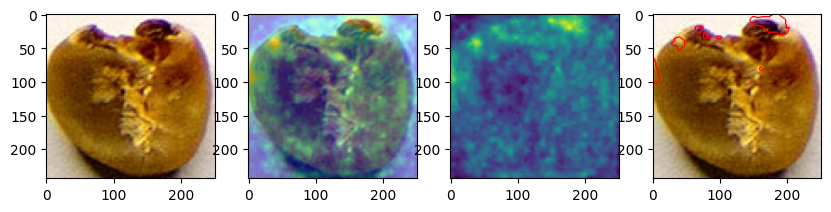

In [176]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(10, 3)
axes[0].imshow(predictions.image)
axes[1].imshow(predictions.heat_map)
axes[2].imshow(predictions.anomaly_map)
axes[3].imshow(predictions.segmentations)